In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pandas as pd
import random
import tqdm

from models.BR_model import SimpleBRModel


print(f"Running on PyMC v{pm.__version__}")
az.style.use("arviz-darkgrid")

Running on PyMC v5.16.2


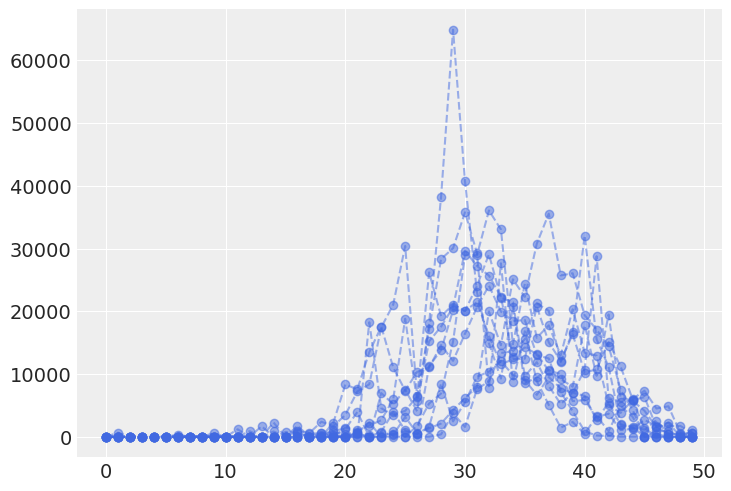

In [2]:
# observed_data = pd.read_csv('sample_data.csv')['incidence']
num_seasons = 10
data = [[]]*num_seasons
for index in range(num_seasons):
    season_data = pd.read_csv(f'epid_data/epid_influenza_season_{index}.csv')['incidence'].to_list()
    data[index] = season_data
for season in data:
    plt.plot(season, '--o', color='royalblue', alpha=0.5)
season_len = len(data[0])

In [3]:
def simulation_func(rng, alpha, beta, size=None):
    ''' Simulation function for use in pm.Simulator'''
    br_model = SimpleBRModel(alpha=alpha, beta=beta, initial_infectious=100, rho=5e5, 
                             br_func_array=[0.1, 0.1, 1, 0.9, 0.55, 0.3, 0.15, 0.05])
    br_model.simulate(modeling_duration=season_len)
    return br_model.newly_infected


In [4]:
abc_data = [[]]*num_seasons
with pm.Model() as model:
    alpha = pm.Uniform(name="alpha", lower=0, upper=1)
    beta = pm.Uniform(name="beta", lower=0, upper=1)
    sim = pm.Simulator("sim", simulation_func, params=(alpha, beta), 
                    epsilon=10, observed=data[index])
    idata = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/opt/miniconda3/envs/.env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [48]:
with pm.Model() as model:
    alpha = pm.Uniform(name="alpha", lower=0, upper=1)
    beta = pm.Uniform(name="beta", lower=0, upper=1)
    sim = pm.Simulator("sim", simulation_func, params=(alpha, beta), 
                    epsilon=10, observed=data[9])
    idata = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/opt/miniconda3/envs/.env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [49]:
abc_data[9] = idata

In [50]:
abc_data

[Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data]

In [22]:
print(np.percentile(idata.posterior.beta, 5))
print(np.percentile(idata.posterior.beta, 95))

0.9999794448114293
0.999997727420846


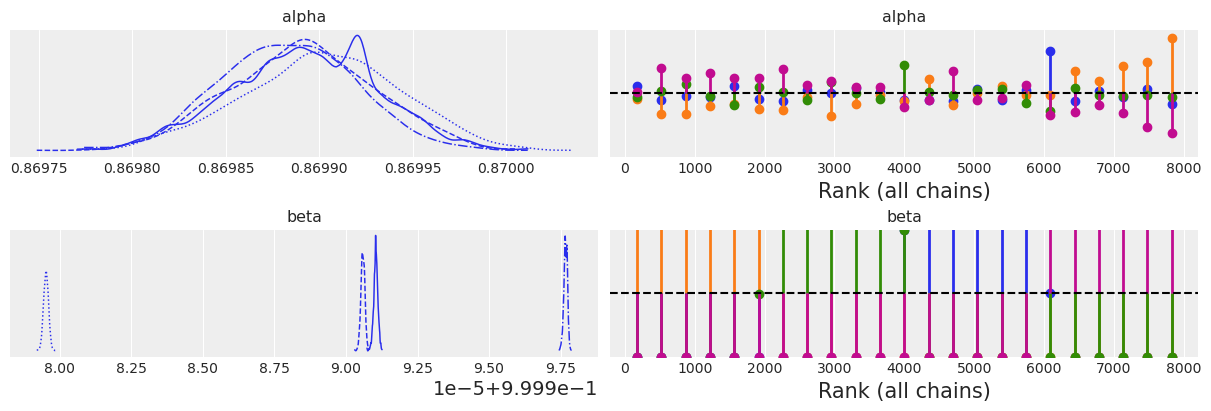

In [40]:
az.plot_trace(idata, kind="rank_vlines");

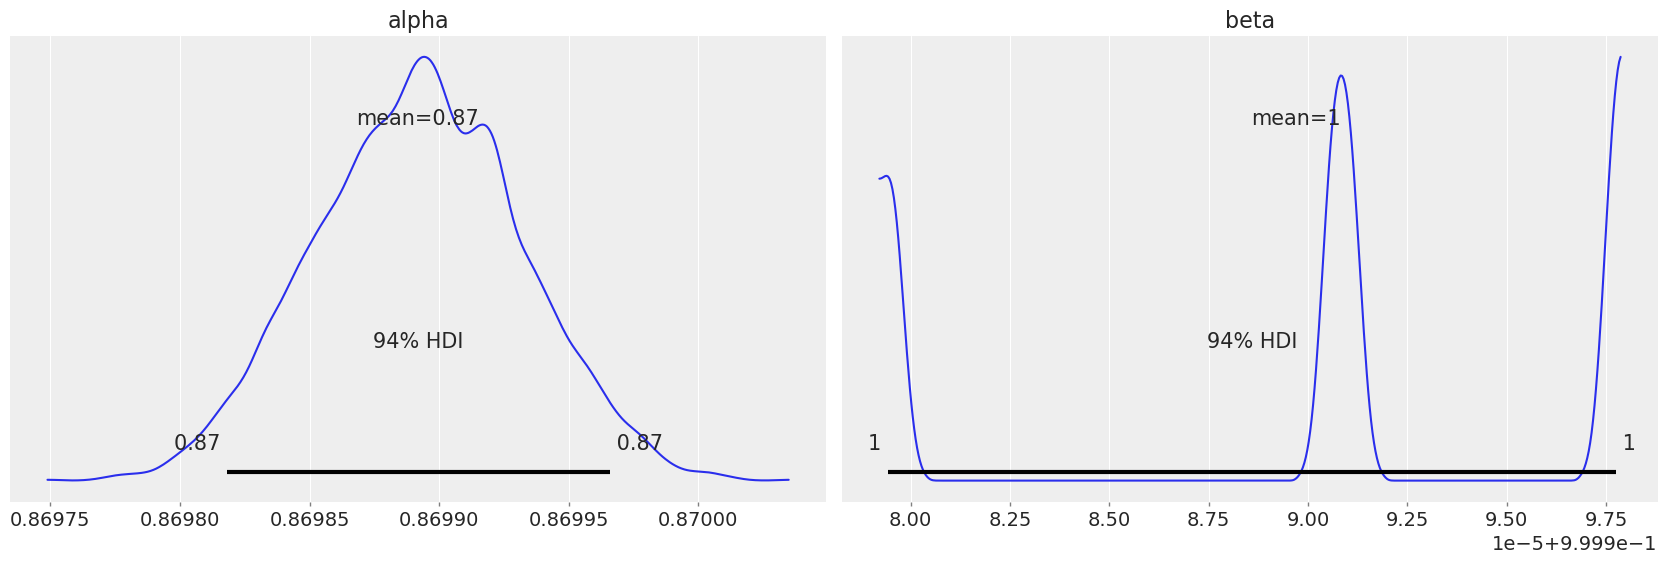

In [23]:
az.plot_posterior(idata);

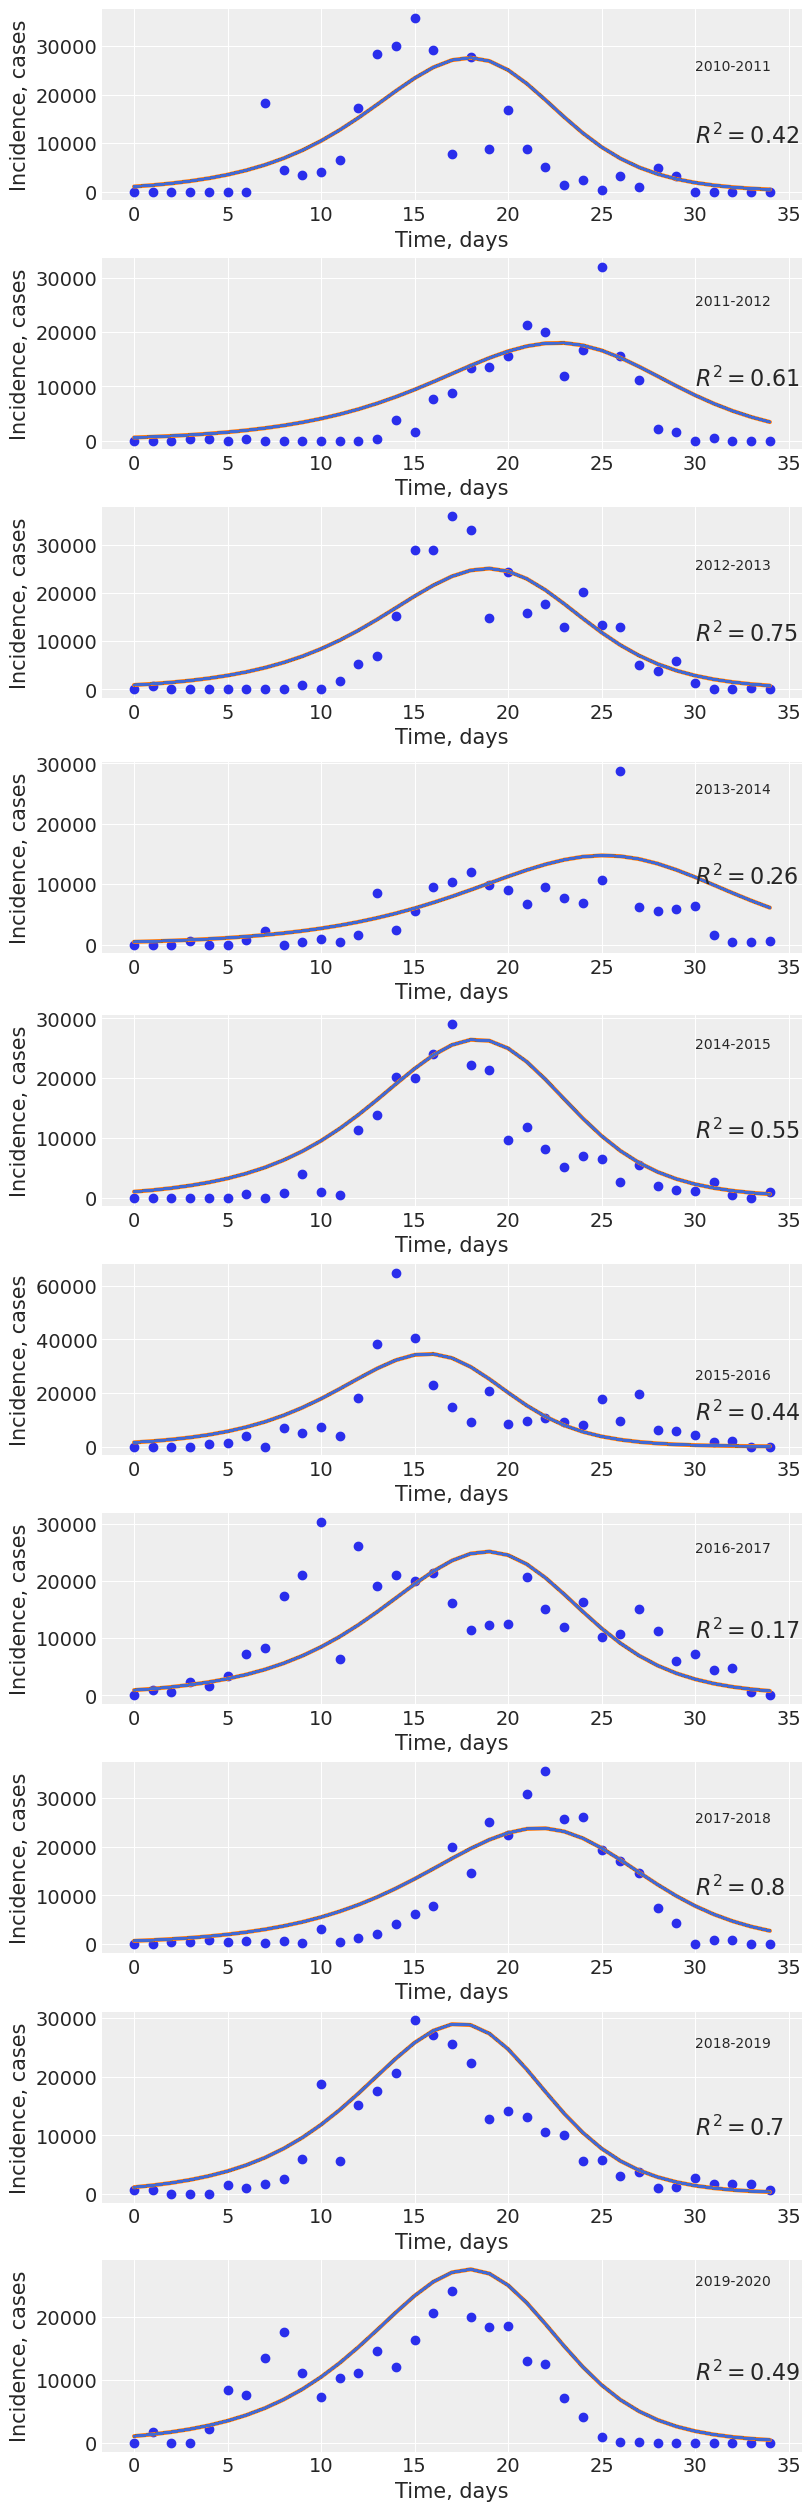

In [55]:
from sklearn.metrics import r2_score
fig, ax = plt.subplots(10, 1, figsize=(8, 25))
start_day = 15
for index in range(10):
    posterior = abc_data[index].posterior.stack(samples=("draw", "chain"))
    ax[index].plot(data[index][start_day:], "o")
    ax[index].plot(simulation_func(None, posterior["alpha"].mean(), posterior["beta"].mean())[start_day:], 
                   linewidth=3)
    for i in np.random.randint(0, 500, 75):
        sim = simulation_func(None, posterior["alpha"][i], posterior["beta"][i])
        ax[index].plot(sim[start_day:], alpha=0.1, c="royalblue")
    ax[index].set_xlabel("Time, days")
    ax[index].set_ylabel("Incidence, cases")
    r2_score_val = round(r2_score(data[index][start_day:], 
                                  simulation_func(None, posterior["alpha"].mean(), posterior["beta"].mean())[start_day:]), 2)
    ax[index].text(30, 1e4, r'$R^2={}$'.format(r2_score_val), fontsize=16)
    year = 2010 + index
    ax[index].text(30, 25000, f'{year}-{year+1}')
fig.savefig(f'plots/calibration_seasons.png', dpi=400);

In [25]:
from sklearn.metrics import r2_score
r2_score(data[0], simulation_func(None, posterior["alpha"].mean(), posterior["beta"].mean()))

0.5748297132628546